# Import libraries

In [40]:
import scipy as sc
from scipy.integrate import odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from mpl_toolkits import mplot3d

# Add real data

In [2]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find growth rate f to first order

## Define useful functions

In [11]:
#---- USEFUL FUNCTIONS for growth rate f ----

# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(x, cosmo, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return k**2/(k**2 + 6*alpha_C*np.exp(-2*x))

# Define E = H/H0
def E(x,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*np.exp(-3*x) + (Omega_r + alpha_C)*np.exp(-4*x) + Omega_k*np.exp(-2*x) +Omega_lambda)

# derivative of the growth rate f with the logarithm of the scale factor x = ln(a) 
def dfdx(f , x , args):
    cosmo, k = args
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return (3*Omega_m * np.exp(-3*x) *xi(x,cosmo,k)/(2*E(x,cosmo)**2)) - f**2 \
          - (2 -(3*Omega_m*np.exp(-3*x) + 4*(Omega_r + alpha_C)*np.exp(-4*x) \
                 + 2*Omega_k*np.exp(-2*x))/(2*E(x,cosmo)**2))*f


In [45]:
# CREATE BOUNDARY CONDITION FOR f(k,z,cosmo) and DEFINE EQUATIONS TO FIND f(k,z,cosmo)
# in matter dominated universe (Omg_m*(1+z)**3 >> Omg_l, Omg_m >> Omg_r*(1+z)) D(a) = a, f(a) = 1

# correction due to not being in matter-dominated era - radiation-domination
def Cort3(cosmo, z):
    return (cosmo[3]+cosmo[4])*(1+z)/(cosmo[0] + cosmo[1])

# correction due to not being in matter-dominated era - DE domination
def Cort2(cosmo, z):
    return(1 + cosmo[4] - (cosmo[0] + cosmo[1]))/((cosmo[0] + cosmo[1])*(1+z)**3) 

# correction due to large xi (or small wavevector)
def Cort_xi(cosmo, z, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo
    return 18*alpha_C*(1+z)**2/k**2

# Ensures we use the BCs only if we are at an initial redshift of matter domination
def BoundaryCondition(z,cosmo,k):
    # ensure error message pops up if errors are too big
    if 1 < max(Cort3(cosmo, z)):
        ans = "Not in matter-dominated era. We need alpha_C = ", 1/((4*(cosmo[0]  + cosmo[1])*(1+z)) - cosmo[3])
        print(ans)
    elif 1 < max(Cort2(cosmo, z)):
        ans = "Change initial conditions. Not in matter dominated era, with density ratios", (cosmo[0]  + cosmo[1])/(cosmo[3]*(1+z)), \
        (cosmo[0]  + cosmo[1])*(1+z)**3/(1 - (cosmo[0]  + cosmo[1]) - cosmo[2] - cosmo[3])
    elif 1 < max(Cort_xi(cosmo, z, k)):
        ans = "k is too small and we are not in matter domination. Need k = ", np.sqrt(18*cosmo[-1]*(1+z)**2)
        print(ans)
    else:
        ans = 1 - 2*Cort3(cosmo,z)/3 + Cort_xi(cosmo, z , k) - 6*Cort2(cosmo,z)/11
    return ans

# gives index of ideal z for boundary condition, given an array of z values and a cosmology
# We do this by minimizing the square of our corrections due to xi, DE and radiation domination
def find_indx_BC(z, cosmo, k):
    arg_z_min = np.zeros(len(k))
    for i in range(len(k)):
        arg_z_min[i] = int(np.argmin((- 2*Cort3(cosmo,z)/3 + Cort_xi(cosmo, z , k[i]) - 6*Cort2(cosmo,z)/11)**2))
    return arg_z_min

def find_f_4DEGB(z,cosmo,k):
    x = np.log(1/(1+z))
    # find z for boundary condition
    z_BC = np.zeros(len(k))
    indx = find_indx_BC(z, cosmo, k)
    for i in range(len(k)):
        z_BC[i] = z[int(indx[i])] # Redshift our BC occurs at
    # estimates of BC
    BC = BoundaryCondition(z_BC,cosmo,k)
    # errors in our estimates of the BC - if more than 1% returns an error
    BC_err = Cort3(cosmo, z_BC)**2 + Cort_xi(cosmo, z_BC , k)**2
    if max(abs(BC_err/BC)) > 0.01:
        return "error: can't measure f accurately enough"
    else:
        #find solution - 4DEGB
        f = np.zeros((len(k),len(z)))
        f_max = np.zeros((len(k),len(z)))
        f_min = np.zeros((len(k),len(z)))
        for i in range(len(k)):
            f1 = np.transpose(odeint(dfdx, BC[i], np.flip(x[:int(indx[i])]), args=((cosmo,k[i]),), mxstep=int(1e4)))
            f2 = np.transpose(odeint(dfdx, BC[i], x[int(indx[i]):], args=((cosmo,k[i]),), mxstep=int(1e4)))
            f[i] = np.append(np.flip(f1[0]),f2[0])
        return f

def find_f_LCDM(z, cosmo):
    x = np.log(1/(1+z))
    # find z for boundary condition
    indx = int(find_indx_BC(z, cosmo_LCDM_array, [1,1])[0])
    z_BC_LCDM = z[indx]
    # estimates of BC
    BC_LCDM = BoundaryCondition(np.array([z_BC_LCDM,z_BC_LCDM]),cosmo_LCDM_array,1)[0]
    # errors in our estimates of the BC
    BC_err_LCDM = Cort3(cosmo_LCDM_array, np.array([z_BC_LCDM,z_BC_LCDM]))[0]**2
    if BC_err_LCDM/BC_LCDM > 0.01:
        return "error: can't measure f accurately enough"
    f1 = np.transpose(odeint(dfdx, BC_LCDM, x[indx:], args=((cosmo_LCDM_array,1),), mxstep=int(1e4)))[0]
    f2 = np.transpose(odeint(dfdx, BC_LCDM, np.flip(x[:indx]), args=((cosmo_LCDM_array,1),), mxstep=int(1e4)))[0]
    f = np.append(np.flip(f2),f1)
    return f

## Define cosmology, scales and boundary condition corrections

In [46]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.linspace(4, 3e5*np.pi/200, int(1e3))

# Decide on some coordinate times
p = 4
x_val = np.linspace( -8, 0 , int(10**p))
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-8]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

error in k_simga8 =  0.015132496180504551 %


In [47]:
# --- FINDING SOLUTIONS ------

#find solution - 4DEGB
f = find_f_4DEGB(z_val,cosmo,k_val)

#find solution - LCDM
f_LCDM = find_f_LCDM(z_val, cosmo_LCDM_array)

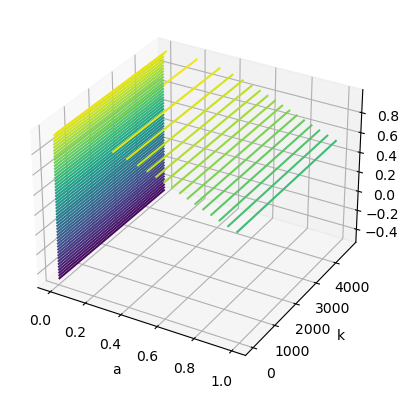

In [48]:
# 3D plot of f(a,k)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(a_val, k_val, f, 50)
ax.set_xlabel('a')
ax.set_ylabel('k')
ax.set_zlabel('f');

# Plot growth rate f and the fractional difference to LCDM

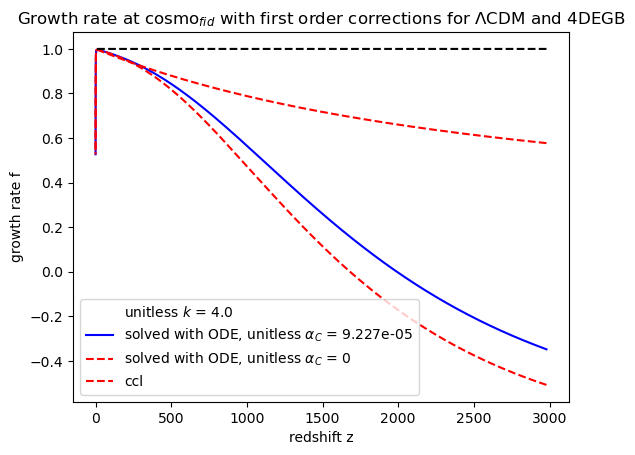

In [49]:
# plot of the growth rate with theoretical errors to to initial BC assumption, LDCM and 4DEGB
# function of z

plt.title(r"Growth rate at cosmo$_{fid}$ with first order corrections for $\Lambda$CDM and 4DEGB")
plt.plot(0,0.8,color = "white", label = r"unitless $k$ = {}".format(k_val[0]))
plt.plot(z_val,f[0], color = "b", label = r"solved with ODE, unitless $\alpha_C$ = {}".format(cosmo[-2]))

plt.plot(z_val,f_LCDM, color = "r", label = r"solved with ODE, unitless $\alpha_C$ = 0", linestyle="--")

plt.plot(z_val[:find_nearest(a_val, 1e-5)-1], ccl.growth_rate(cosmoLCDM,a_val[:find_nearest(a_val, 1e-5)-1]), color = "r", linestyle='dashed', label = "ccl")

plt.plot(z_val, np.ones(len(z_val)), color = "black", linestyle = "dashed")

#plt.plot(z[7000:], ((cosmo[0] + cosmo[1])*(1+z[7000:])**3/E(x[7000:],cosmo))**0.55, color = "gray", linestyle = "dashed", label = r"$\Omega_m(a)^{0.55}$")

plt.xlabel("redshift z")
plt.ylabel("growth rate f")
#plt.xscale('log')
plt.legend()
plt.show()